# Table of Contents
- [STATIONARITY & TRANSFORMATIONS](#stationarity--transformations)
   - [Data Cleaning](#data-cleaning)
     - [Missing Values](#missing-values)
     - [Outliers](#outliers)
   - [Stationarity](#STATIONARITY)
     - [ACF and PACF functions](#acf-and-pacf-functions)
     - [Statistical Tests](#statistical-tests)
   - [Transformation](#transformation)
- [ARIMA MODEL](#arima-model)


In [148]:
# import packages   
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import IsolationForest

from statsmodels.tsa.stattools import adfuller, kpss

# STATIONARITY & TRANSFROMATIONS

## Data Cleaning

Clean the data of outliers or breaks

### Missing Values

In [149]:
# Load data
os.chdir('.')  # Set working directory to your file's location
df = pd.read_csv('data_Naseh.csv')
df.columns = ['date', 'y']

# Convert 'date' column to datetime and check its data type
df['date'] = pd.to_datetime(df['date'])
print("Data types after converting 'date':\n", df.dtypes)
print("-"*50)

# Remove time part (hour:min:sec) from 'date' column
df['date'] = df['date'].dt.date
print("Data types after removing time part from 'date':\n", df.dtypes)
print("-"*50)

# Convert 'y' column to numeric and check its data type
df['y'] = pd.to_numeric(df['y'], errors='coerce')
print("Data types after converting 'y' to numeric:\n", df.dtypes)
print("-"*50)

Data types after converting 'date':
 date    datetime64[ns]
y               object
dtype: object
--------------------------------------------------
Data types after removing time part from 'date':
 date    object
y       object
dtype: object
--------------------------------------------------
Data types after converting 'y' to numeric:
 date     object
y       float64
dtype: object
--------------------------------------------------


In [150]:
print("Missing values:\n", df.isna().sum())

# Fill missing values in 'y' using a moving average with a specified window size
window_size = 5
df['y'] = df['y'].fillna(df['y'].rolling(window=window_size, min_periods=1).mean())

print("Missing values after Moving Average:\n", df.isna().sum())

Missing values:
 date      0
y       267
dtype: int64
Missing values after Moving Average:
 date    0
y       0
dtype: int64


We can replace each missing point with the average of the rolling window around it.
this code effectively addresses breaks by identifying missing values in the y column and then filling these breaks with a smoothed estimate (moving average), thus maintaining continuity in the time series data.

### Outliers

In [151]:
# Calculate the first and third quartiles (Q1 and Q3)
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
df['outlier_iqr'] = (df['y'] < lower_bound) | (df['y'] > upper_bound)

# Count the number of outliers detected
outliers_count = df['outlier_iqr'].sum()
print(f"Number of outliers detected: {outliers_count}")

Number of outliers detected: 0


the IQR method didn’t detect any outliers, this might suggest that the data doesn’t have extreme values based on the overall distribution. However, in time series data, outliers can sometimes be better identified using a moving statistics approach because it focuses on local deviations, which are often more relevant in time-based data.

In [152]:
# Define the rolling window size
window_size = 10

# Calculate the rolling mean and rolling standard deviation
rolling_mean = df['y'].rolling(window=window_size, center=True).mean()
rolling_std = df['y'].rolling(window=window_size, center=True).std()

# Define outliers as points beyond 3 standard deviations from the rolling mean
df['outlier_moving'] = ((df['y'] > rolling_mean + 3 * rolling_std) | 
                        (df['y'] < rolling_mean - 3 * rolling_std))

# Count the number of outliers detected
outliers_count_moving = df['outlier_moving'].sum()
print(f"Number of outliers detected with moving method: {outliers_count_moving}")

Number of outliers detected with moving method: 0


Here we compute a rolling mean and rolling standard deviation over a specified window and then flag data points that deviate significantly from the rolling mean (e.g., by more than 3 standard deviations).

In [153]:
# Train Isolation Forest
model = IsolationForest(contamination=0.001)  # we can set contamination to adjust sensitivity
df['outlier_iforest'] = model.fit_predict(df[['y']]) == -1

# Count the number of outliers detected
outliers_count_iforest = df['outlier_iforest'].sum()
print(f"Number of outliers detected with Isolation Forest: {outliers_count_iforest}")

Number of outliers detected with Isolation Forest: 10


with [IsolationForest](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.IsolationForest.html) method 10 outliers are detected. 

Isolation Forest is an unsupervised machine learning algorithm designed specifically for detecting anomalies or outliers in data. Unlike traditional statistical methods, such as the Interquartile Range (IQR) or moving averages, which can miss subtle or complex outliers, Isolation Forest excels by isolating data points through random partitioning. This approach is particularly effective in identifying anomalies in complex, high-dimensional data. Isolation Forest works by constructing multiple binary trees, known as isolation trees, where each data point is "isolated" through random splits. Points that are isolated quickly, requiring fewer splits, are considered likely anomalies. The algorithm assigns an anomaly score based on the average path length across these trees—data points with shorter average path lengths are flagged as potential outliers. Because it does not rely on distance or density measures, Isolation Forest is both efficient and adaptable to various data distributions, making it a robust choice for detecting outliers in our time series dataset.

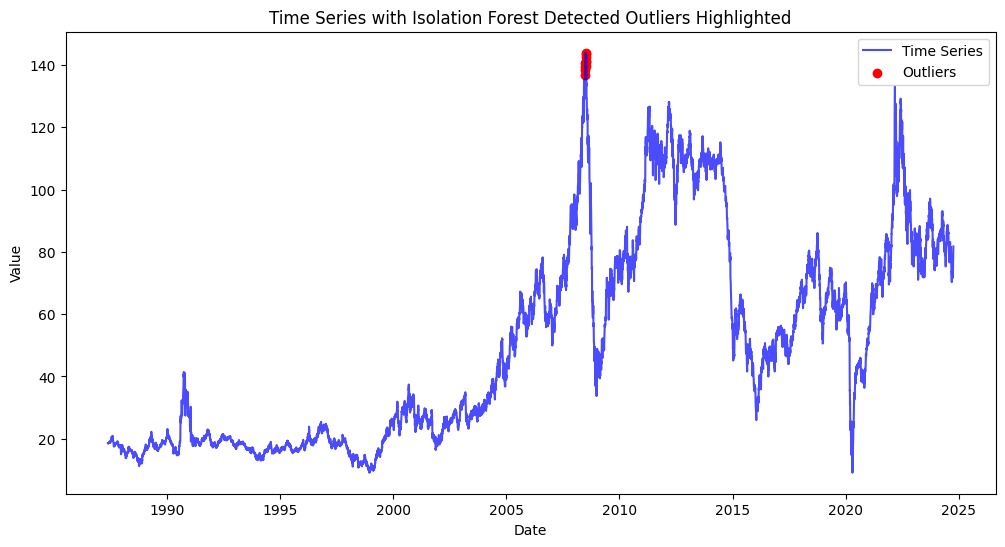

In [154]:
# Plot the entire time series
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['y'], label='Time Series', color='blue', alpha=0.7)

# Highlight detected outliers in red
plt.scatter(df['date'][df['outlier_iforest']], df['y'][df['outlier_iforest']], color='red', label='Outliers', marker='o')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series with Isolation Forest Detected Outliers Highlighted')
plt.legend()
plt.show()

In [155]:
# Define a rolling window size
window_size = 5

# Replace outliers with rolling mean
df['y'] = df['y'].where(~df['outlier_iforest'], df['y'].rolling(window=window_size, min_periods=1).mean())

We replaced each outlier with the average or median of a surrounding window of values. This smooths out the effect of the outlier, maintaining the overall trend without the influence of extreme values.

## STATIONARITY

Decide and describe whether the series is stationary or not. support your argument with ACF and PACF functions, as well as statistical tests.

### ACF and PACF functions

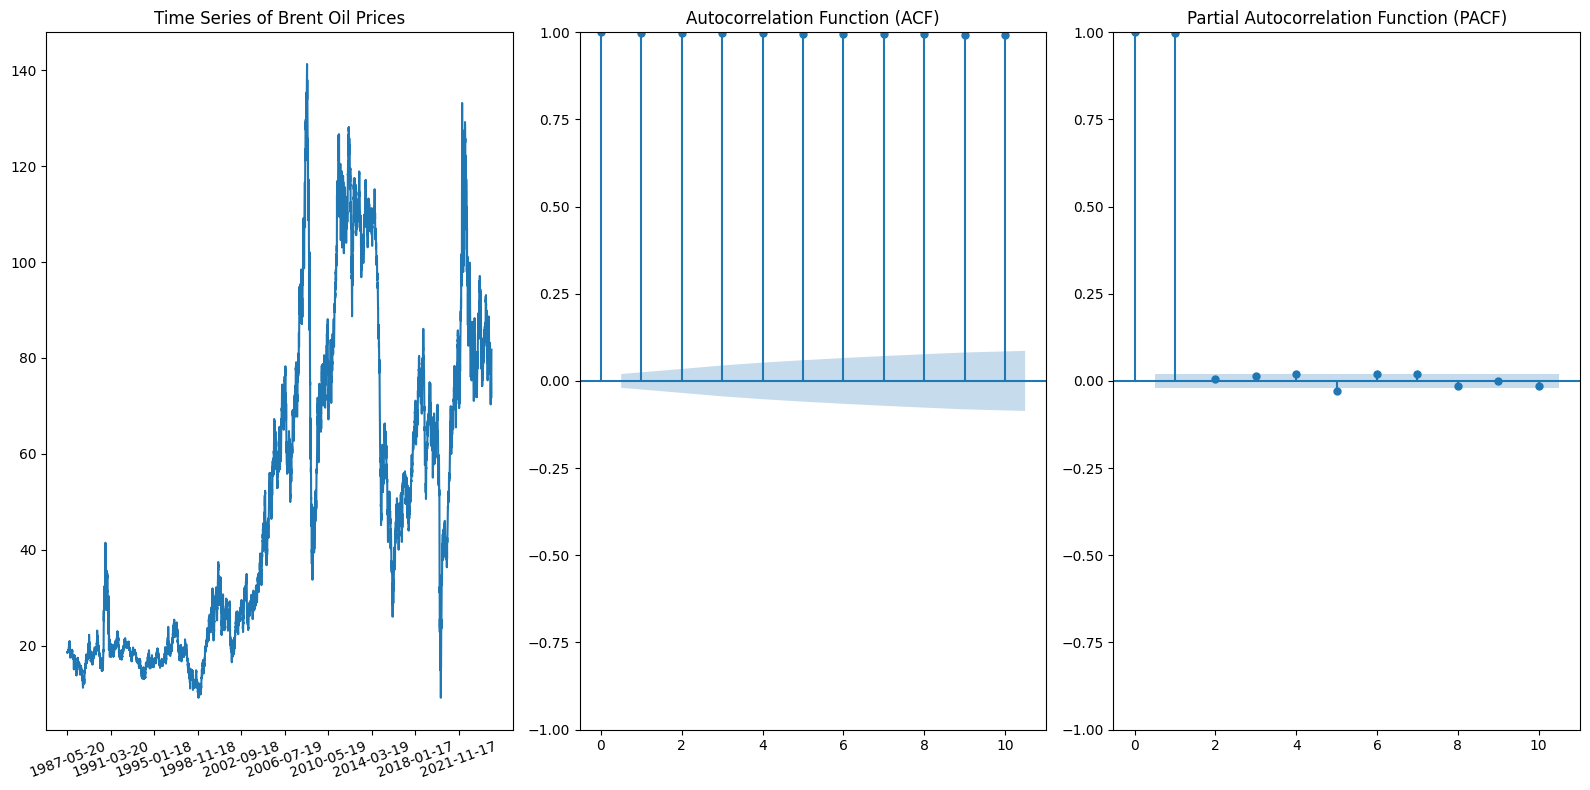

In [156]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot the 'y' column (oil prices over time)
n_tick = 1000  # Number of ticks to display
axs[0].plot(df.y)

# Set x-ticks and x-tick labels
xticks = np.arange(0, len(df.y), n_tick)
axs[0].set_xticks(xticks)

# Ensure that the number of labels matches the number of ticks
xtick_labels = df.date.iloc[xticks].astype(str)  # Convert dates to strings for labeling
axs[0].set_xticklabels(xtick_labels, rotation=20)

# Set title for the first plot
axs[0].set_title('Time Series of Brent Oil Prices')

# Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF)
sm.graphics.tsa.plot_acf(df.y, lags=10, ax=axs[1])
axs[1].set_title('Autocorrelation Function (ACF)')

sm.graphics.tsa.plot_pacf(df.y, lags=10, ax=axs[2])
axs[2].set_title('Partial Autocorrelation Function (PACF)')

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Show the plots
plt.show()

- **Time Series Plot:**
The time series shows clear upward and downward trends over different periods, along with noticeable peaks and troughs.
This suggests non-stationarity, as the series does not have a constant mean or variance over time.

- **Autocorrelation Function (ACF) Plot:**
The ACF plot shows significant autocorrelation at multiple lags, with slow decay. This is typical for non-stationary series, as the values are highly correlated with previous values.
Slow decay in the ACF indicates a trend or persistence over time, which reinforces the likelihood of non-stationarity.

- **Partial Autocorrelation Function (PACF) Plot:**
The PACF shows a high value at the first lag and then drops off significantly.
This pattern can sometimes suggest that the series may become stationary after differencing once, as a single significant PACF lag indicates a potential AR(1) process in a differenced series.


### Statistical Tests

To statistically determine whether the time series is stationary, we use two stationarity tests as the **Augmented Dickey-Fuller (ADF)** Test and **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)** Test.

The **ADF** test is used to check for the presence of a unit root in the series, which indicates non-stationarity.
- Null Hypothesis $(H_0)$: The series has a unit root (it is non-stationary).
- Alternative Hypothesis $(H_1)$: The series is stationary.
- Interpretation: If the p-value is less than 0.05, we reject the null hypothesis and conclude that the series is stationary. If the p-value is greater than 0.05, we fail to reject the null, indicating that the series is likely non-stationary.

The **KPSS** test is another statistical test for stationarity, but with the opposite null hypothesis compared to the ADF test.
- Null Hypothesis (H0): The series is stationary.
- Alternative Hypothesis (H1): The series is non-stationary.
- Interpretation: If the p-value is less than 0.05, we reject the null hypothesis and conclude that the series is likely non-stationary.

In [157]:
# Augmented Dickey-Fuller (ADF) Test
adf_test = adfuller(df['y'], maxlag=30, regression='ct', autolag='AIC') # 'c' for constant, 'ct' for constant + trend
print("Augmented Dickey-Fuller (ADF) Test:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")
if adf_test[1] < 0.05:
    print("Conclusion: The series is likely stationary (p-value < 0.05).")
else:
    print("Conclusion: The series is likely non-stationary (p-value >= 0.05).")

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_test = kpss(df['y'], regression='ct', nlags='auto')  # 'c' for constant, 'ct' for constant + trend
print("\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
print(f"KPSS Statistic: {kpss_test[0]}")
print(f"p-value: {kpss_test[1]}")
print("Critical Values:")
for key, value in kpss_test[3].items():
    print(f"   {key}: {value}")
if kpss_test[1] < 0.05:
    print("Conclusion: The series is likely non-stationary (p-value < 0.05).")
else:
    print("Conclusion: The series is likely stationary (p-value >= 0.05).")

Augmented Dickey-Fuller (ADF) Test:
ADF Statistic: -3.1769902613413725
p-value: 0.08908494750537282
Critical Values:
   1%: -3.959701402366351
   5%: -3.4109416435074316
   10%: -3.127315967697082
Conclusion: The series is likely non-stationary (p-value >= 0.05).

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
KPSS Statistic: 1.1290071676259923
p-value: 0.01
Critical Values:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216
Conclusion: The series is likely non-stationary (p-value < 0.05).


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_8877/2484793854.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df['y'], regression='ct', nlags='auto')  # 'c' for constant, 'ct' for constant + trend


In Augmented Dickey-Fuller (ADF) Test, since the p-value (0.0873) is greater than 0.05, we fail to reject the null hypothesis of the ADF test, which suggests that the series is likely non-stationary.
In Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test, since the p-value (0.01) is less than 0.05, meaning we reject the null hypothesis of the KPSS test, indicating non-stationarity. The KPSS test output also provided a warning (InterpolationWarning), which indicates that the test statistic is quite high, further reinforcing the presence of non-stationarity.

Both the ADF and KPSS tests suggest that the series is non-stationary.

## Transformation

Explain which transformation you will use to make the series stationary and 
ready for modelling.

this series appears to be non-stationary and to make it stationary, we will apply first-order differencing. This transformation can often remove trends and stabilize the mean.

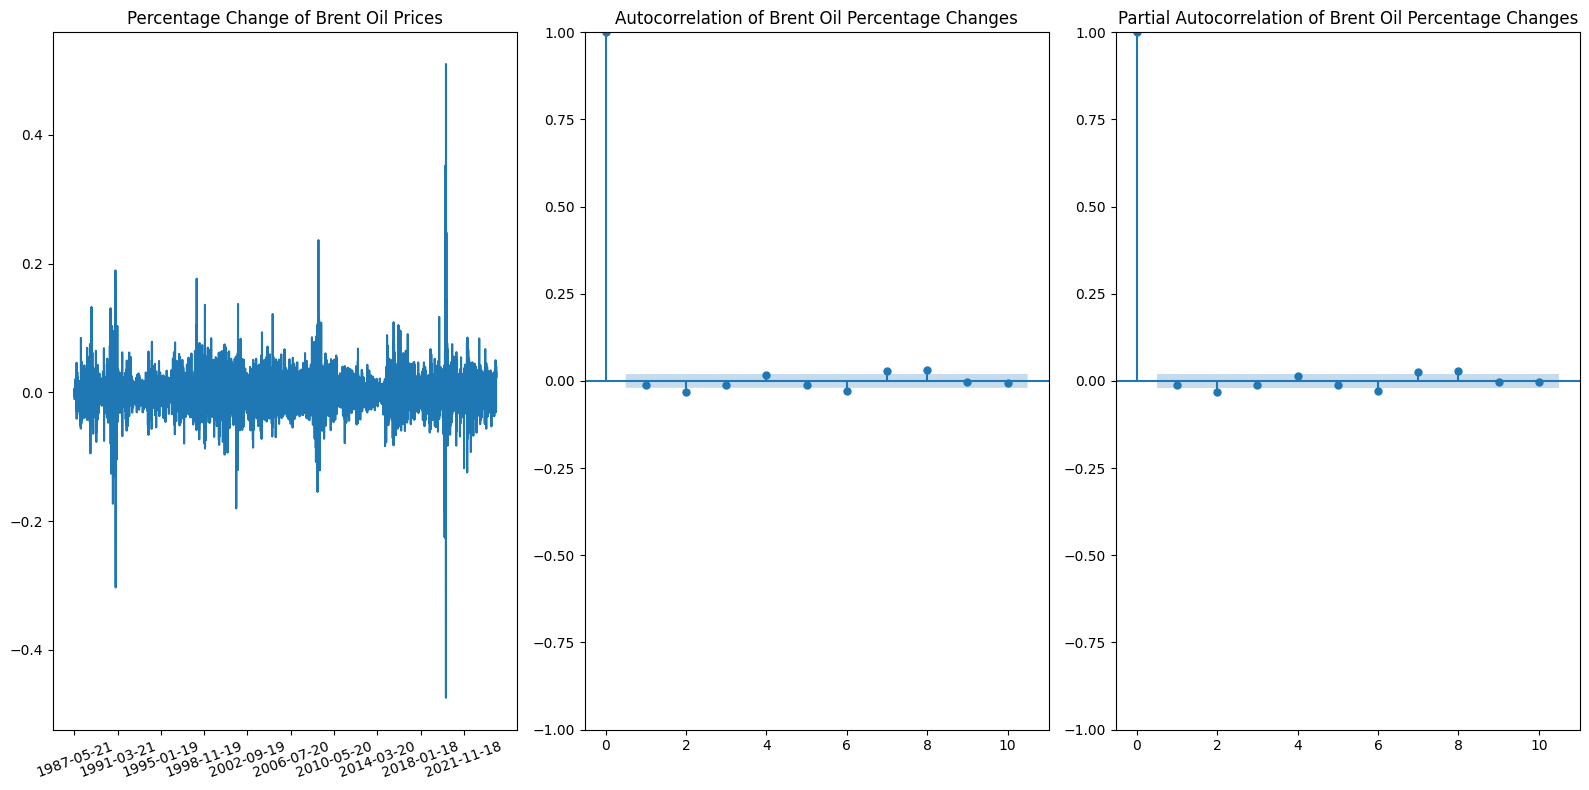

In [158]:
# Calculate percentage change
df['dy'] = df['y'].pct_change()

# Drop NaN values after calculating percentage change
df_dy = df.dropna(subset=['dy']).reset_index(drop=True)  # Reset index after dropping NaNs

# Plots
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot the percentage change (dy)
n_tick = 1000  # Set tick frequency
axs[0].plot(df_dy['dy'])

# Set x-ticks and x-tick labels
xticks = np.arange(0, len(df_dy['dy']), n_tick)  # Display every n-th tick
axs[0].set_xticks(xticks)

# Ensure that the number of labels matches the number of ticks
xtick_labels = df_dy['date'].iloc[xticks].astype(str)  # Extract corresponding date labels
axs[0].set_xticklabels(xtick_labels, rotation=20)

# Set title for the first plot
axs[0].set_title('Percentage Change of Brent Oil Prices')

# Plot the autocorrelation function (ACF) for percentage changes
sm.graphics.tsa.plot_acf(df_dy['dy'], lags=10, ax=axs[1])
axs[1].set_title('Autocorrelation of Brent Oil Percentage Changes')

# Plot the partial autocorrelation function (PACF) for percentage changes
sm.graphics.tsa.plot_pacf(df_dy['dy'], lags=10, ax=axs[2])
axs[2].set_title('Partial Autocorrelation of Brent Oil Percentage Changes')

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Show the plots
plt.show()

In [159]:
# Augmented Dickey-Fuller (ADF) Test
adf_test = adfuller(df_dy['dy'], maxlag=30, regression='c', autolag='AIC') # 'c' for constant, 'ct' for constant + trend
print("Augmented Dickey-Fuller (ADF) Test:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")
if adf_test[1] < 0.05:
    print("Conclusion: The series is likely stationary (p-value < 0.05).")
else:
    print("Conclusion: The series is likely non-stationary (p-value >= 0.05).")

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_test = kpss(df_dy['dy'], regression='c', nlags='auto')  # 'c' for constant, 'ct' for constant + trend
print("\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
print(f"KPSS Statistic: {kpss_test[0]}")
print(f"p-value: {kpss_test[1]}")
print("Critical Values:")
for key, value in kpss_test[3].items():
    print(f"   {key}: {value}")
if kpss_test[1] < 0.05:
    print("Conclusion: The series is likely non-stationary (p-value < 0.05).")
else:
    print("Conclusion: The series is likely stationary (p-value >= 0.05).")

Augmented Dickey-Fuller (ADF) Test:
ADF Statistic: -17.943078322399337
p-value: 2.8561082839579016e-30
Critical Values:
   1%: -3.43102246083597
   5%: -2.8618371867694483
   10%: -2.5669281873942427
Conclusion: The series is likely stationary (p-value < 0.05).

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
KPSS Statistic: 0.03717226133176183
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: The series is likely stationary (p-value >= 0.05).


/var/folders/l0/k7f2rhdj5xg3__zf2_xlw76c0000gn/T/ipykernel_8877/3832412310.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(df_dy['dy'], regression='c', nlags='auto')  # 'c' for constant, 'ct' for constant + trend


Number of outliers detected with Isolation Forest on dy: 9


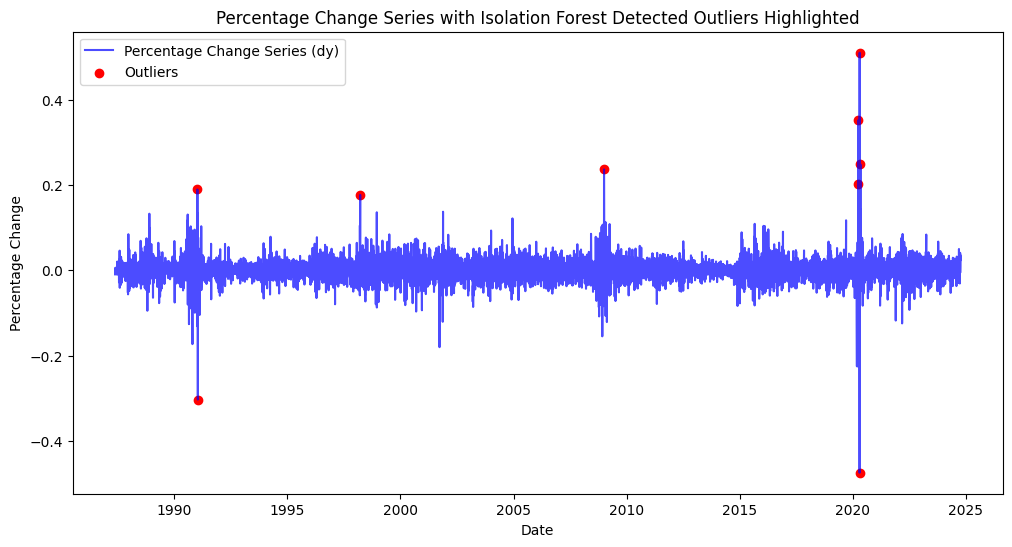

In [160]:
# Train Isolation Forest on df_dy for dy (percentage changes)
model_dy = IsolationForest(contamination=0.001)
df_dy['outlier_iforest_dy'] = model_dy.fit_predict(df_dy[['dy']]) == -1

# Count the number of outliers detected
outliers_count_iforest_dy = df_dy['outlier_iforest_dy'].sum()
print(f"Number of outliers detected with Isolation Forest on dy: {outliers_count_iforest_dy}")

# Plot the percentage change series with outliers
plt.figure(figsize=(12, 6))
plt.plot(df_dy['date'], df_dy['dy'], label='Percentage Change Series (dy)', color='blue', alpha=0.7)

# Highlight detected outliers in red
plt.scatter(df_dy['date'][df_dy['outlier_iforest_dy']], df_dy['dy'][df_dy['outlier_iforest_dy']], color='red', label='Outliers', marker='o')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.title('Percentage Change Series with Isolation Forest Detected Outliers Highlighted')
plt.legend()
plt.show()


In [161]:
# Smooth only the outliers with a rolling mean
df_dy['dy_smoothed'] = df_dy['dy']
outlier_indices = df_dy['outlier_iforest_dy']
df_dy.loc[outlier_indices, 'dy_smoothed'] = df_dy['dy'].rolling(window=7, min_periods=1).mean()[outlier_indices]

In [162]:
df_dy

,date,y,outlier_iqr,outlier_moving,outlier_iforest,dy,outlier_iforest_dy,dy_smoothed
0,1987-05-21,18.45,False,False,False,-0.009662,False,-0.009662
1,1987-05-22,18.55,False,False,False,0.005420,False,0.005420
2,1987-05-25,18.60,False,False,False,0.002695,False,0.002695
3,1987-05-26,18.63,False,False,False,0.001613,False,0.001613
4,1987-05-27,18.60,False,False,False,-0.001610,False,-0.001610
...,...,...,...,...,...,...,...,...
9748,2024-10-01,75.30,False,False,False,0.040774,False,0.040774
9749,2024-10-02,74.86,False,False,False,-0.005843,False,-0.005843
9750,2024-10-03,77.57,False,False,False,0.036201,False,0.036201
9751,2024-10-04,79.32,False,False,False,0.022560,False,0.022560


# ARIMA MODEL

 [ARIMA MODEL]: Take the stationary series from point 1, use the first 80% of the sample 
for estimation, and select an appropriate ARIMA model. Justify your choice by means of tests and 
selection criteria.